# Evaluate p-values on Atari100k test results for different algorithms
Author: r.casesa

The aim of this notebook is to compare different Reinforcement Learning algorithms against the Atari 100k benchmark and evaluate results from the paper "Deep Reinforcement Learning at the Edge of the Statistical Precipice".

The mentioned paper shows how evaluating algorithms based on a few sample's mean or median often leads to uncorrect results and proposes alternative metrics for algorithm evaluation.
We extend the treatment by including statistical tests. 



For each algorithm we plot results and test for normality. In fact t-test can be performed only on normally distributed data.
As the data appears to be non/normally distributed two approaches are tried out:
1. Transform the resulting data using a log transformation. This makes sense in general as data is skewed towards higher values of returns
2. Using tests which assume non normality.
3. Bootstrap data


## Question points
1. How do we handle non-normal data?
2. How do we handle the fact that the comparison should be performed on multiple tasks (games)
3. Which metric we can use?

In [1]:
# Taken from stat_precipice

from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [2]:
# Taken from stat_precipice

# @title Imports
import collections
import numpy as np
import matplotlib.patches as patches
import sys
import pickle
import pandas as pd
import copy
import functools
import json
import os

import itertools as it
import random
import inspect
import scipy.stats
 
import getpass
import os.path as osp
 
# See warnings only once
import warnings
warnings.filterwarnings('default')
 
import inflection
from functools import partial

# The answer to life, universe and everything
RAND_STATE = np.random.RandomState(42)

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
# Taken from stat_precipice

#@title Plotting: Seaborn style and matplotlib params
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style("white")

# Matplotlib params
from matplotlib import rcParams
from matplotlib import rc

rcParams['legend.loc'] = 'best'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rc('text', usetex=False)

In [4]:
# Taken from stat_precipice

#@title Calculate Human AND Random scores

# These are taken from the MuZero paper
# Games Average-Human Random Agent57 R2D2 (Bandit) MuZero
my_str="""alien 7127.70 227.80 297638.17 ± 37054.55 464232.43 ± 7988.66 741812.63
amidar 1719.50 5.80 29660.08 ± 880.39 31331.37 ± 817.79 28634.39
assault 742.00 222.40 67212.67 ± 6150.59 110100.04 ± 346.06 143972.03
asterix 8503.30 210.00 991384.42 ± 9493.32 999354.03 ± 12.94 998425.00
asteroids 47388.70 719.10 150854.61 ± 16116.72 431072.45 ± 1799.13 6785558.64
atlantis 29028.10 12850.00 1528841.76 ± 28282.53 1660721.85 ± 14643.83 1674767.20
bank_heist 753.10 14.20 23071.50 ± 15834.73 27117.85 ± 963.12 1278.98
battle_zone 37187.50 2360.00 934134.88 ± 38916.03 992600.31 ± 1096.19 848623.00
beam_rider 16926.50 363.90 300509.80 ± 13075.35 390603.06 ± 23304.09 4549993.53
berzerk 2630.40 123.70 61507.83 ± 26539.54 77725.62 ± 4556.93 85932.60
bowling 160.70 23.10 251.18 ± 13.22 161.77 ± 99.84 260.13
boxing 12.10 0.10 100.00 ± 0.00 100.00 ± 0.00 100.00
breakout 30.50 1.70 790.40 ± 60.05 863.92 ± 0.08 864.00
centipede 12017.00 2090.90 412847.86 ± 26087.14 908137.24 ± 7330.99 1159049.27
chopper_command 7387.80 811.00 999900.00 ± 0.00 999900.00 ± 0.00 991039.70
crazy_climber 35829.40 10780.50 565909.85 ± 89183.85 729482.83 ± 87975.74 458315.40
defender 18688.90 2874.50 677642.78 ± 16858.59 730714.53 ± 715.54 839642.95
demon_attack 1971.00 152.10 143161.44 ± 220.32 143913.32 ± 92.93 143964.26
double_dunk -16.40 -18.60 23.93 ± 0.06 24.00 ± 0.00 23.94
enduro 860.50 0.00 2367.71 ± 8.69 2378.66 ± 3.66 2382.44
fishing_derby -38.70 -91.70 86.97 ± 3.25 90.34 ± 2.66 91.16
freeway 29.60 0.00 32.59 ± 0.71 34.00 ± 0.00 33.03
frostbite 4334.70 65.20 541280.88 ± 17485.76 309077.30 ± 274879.03 631378.53
gopher 2412.50 257.60 117777.08 ± 3108.06 129736.13 ± 653.03 130345.58
gravitar 3351.40 173.00 19213.96 ± 348.25 21068.03 ± 497.25 6682.70
hero 30826.40 1027.00 114736.26 ± 49116.60 49339.62 ± 4617.76 49244.11
ice_hockey 0.90 -11.20 63.64 ± 6.48 86.59 ± 0.59 67.04
jamesbond 302.80 29.00 135784.96 ± 9132.28 158142.36 ± 904.45 41063.25
kangaroo 3035.00 52.00 24034.16 ± 12565.88 18284.99 ± 817.25 16763.60
krull 2665.50 1598.00 251997.31 ± 20274.39 245315.44 ± 48249.07 269358.27
kung_fu_master 22736.30 258.50 206845.82 ± 11112.10 267766.63 ± 2895.73 204824.00
montezuma_revenge 4753.30 0.00 9352.01 ± 2939.78 3000.00 ± 0.00 0.00
ms_pacman 6951.60 307.30 63994.44 ± 6652.16 62595.90 ± 1755.82 243401.10
name_this_game 8049.00 2292.30 54386.77 ± 6148.50 138030.67 ± 5279.91 157177.85
phoenix 7242.60 761.40 908264.15 ± 28978.92 990638.12 ± 6278.77 955137.84
pitfall 6463.70 -229.40 18756.01 ± 9783.91 0.00 ± 0.00 0.00
pong 14.60 -20.70 20.67 ± 0.47 21.00 ± 0.00 21.00
private_eye 69571.30 24.90 79716.46 ± 29515.48 40700.00 ± 0.00 15299.98
qbert 13455.00 163.90 580328.14 ± 151251.66 777071.30 ± 190653.94 72276.00
riverraid 17118.00 1338.50 63318.67 ± 5659.55 93569.66 ± 13308.08 323417.18
road_runner 7845.00 11.50 243025.80 ± 79555.98 593186.78 ± 88650.69 613411.80
robotank 11.90 2.20 127.32 ± 12.50 144.00 ± 0.00 131.13
seaquest 42054.70 68.40 999997.63 ± 1.42 999999.00 ± 0.00 999976.52
skiing -4336.90 -17098.10 -4202.60 ± 607.85 -3851.44 ± 517.52 -29968.36
solaris 12326.70 1236.30 44199.93 ± 8055.50 67306.29 ± 10378.22 56.62
space_invaders 1668.70 148.00 48680.86 ± 5894.01 67898.71 ± 1744.74 74335.30
star_gunner 10250.00 664.00 839573.53 ± 67132.17 998600.28 ± 218.66 549271.70
surround 6.50 -10.00 9.50 ± 0.19 10.00 ± 0.00 9.99
tennis -8.30 -23.80 23.84 ± 0.10 24.00 ± 0.00 0.00
time_pilot 5229.20 3568.00 405425.31 ± 17044.45 460596.49 ± 3139.33 476763.90
tutankham 167.60 11.40 2354.91 ± 3421.43 483.78 ± 37.90 491.48
up_n_down 11693.20 533.40 623805.73 ± 23493.75 702700.36 ± 8937.59 715545.61
venture 1187.50 0.00 2623.71 ± 442.13 2258.93 ± 29.90 0.40
video_pinball 17667.90 0.00 992340.74 ± 12867.87 999645.92 ± 57.93 981791.88
wizard_of_wor 4756.50 563.50 157306.41 ± 16000.00 183090.81 ± 6070.10 197126.00
yars_revenge 54576.90 3092.90 998532.37 ± 375.82 999807.02 ± 54.85 553311.46
zaxxon 9173.30 32.50 249808.90 ± 58261.59 370649.03 ± 19761.32 725853.90"""


scores = my_str.split('\n')
ALL_HUMAN_SCORES = {}
ALL_RANDOM_SCORES = {}
for sc in scores:
  arr = sc.split(' ')
  game = inflection.camelize(arr[0]) 
  ALL_RANDOM_SCORES[game] = float(arr[2])
  ALL_HUMAN_SCORES[game] = float(arr[1])  

_ = ALL_HUMAN_SCORES.pop('Surround')
_ = ALL_HUMAN_SCORES.pop('Defender')

In [5]:
# Taken from stat_precipice

#@title Record scores on Atari games

ALL_HUMAN_RECORD = {
  'Alien': 251916.0,
  'Amidar': 104159.0,
  'Assault': 8647.0,
  'Asterix': 1000000.0,
  'Asteroids': 10506650.0,
  'Atlantis': 10604840.0,
  'BankHeist': 82058.0,
  'BattleZone': 801000.0,
  'BeamRider': 999999.0,
  'Berzerk': 1057940.0,
  'Bowling': 300.0,
  'Boxing': 100.0,
  'Breakout': 864.0,
  'Centipede': 1301709.0,
  'ChopperCommand': 999999.0,
  'CrazyClimber': 219900.0,
  'DemonAttack': 1556345.0,
  'DoubleDunk': 22.0,
  'Enduro': 9500.0,
  'FishingDerby': 71.0,
  'Freeway': 38.0,
  'Frostbite': 454830.0,
  'Gopher': 355040.0,
  'Gravitar': 162850.0,
  'Hero': 1000000.0,
  'IceHockey': 36.0,
  'Jamesbond': 45550.0,
  'Kangaroo': 1424600.0,
  'Krull': 104100.0,
  'KungFuMaster': 1000000.0,
  'MontezumaRevenge': 1219200.0,
  'MsPacman': 290090.0,
  'NameThisGame': 25220.0,
  'Phoenix': 4014440.0,
  'Pitfall': 114000.0,
  'Pong': 21.0,
  'PrivateEye': 101800.0,
  'Qbert': 2400000.0,
  'Riverraid': 1000000.0,
  'RoadRunner': 2038100.0,
  'Robotank': 76.0,
  'Seaquest': 999999.0,
  'Skiing': -3272.0,
  'Solaris': 111420.0,
  'SpaceInvaders': 621535.0,
  'StarGunner': 77400.0,
  'Tennis': 21.0,
  'TimePilot': 65300.0,
  'Tutankham': 5384.0,
  'UpNDown': 82840.0,
  'Venture': 38900.0,
  'VideoPinball': 89218328.0,
  'WizardOfWor': 395300.0,
  'YarsRevenge': 15000105.0,
  'Zaxxon': 83700.0,
  'AirRaid': 23050.0,
  'Carnival': 2541440.0,
  'ElevatorAction': 156550.0,
  'JourneyEscape': -4317804.0,
  'Pooyan': 13025.0
}

In [6]:
# Taken from stat_precipice

def score_normalization_all_atari(res_dict, record_scores=False):
  games = res_dict.keys()
  norm_baseline = ALL_HUMAN_RECORD if record_scores else ALL_HUMAN_SCORES 
  norm_scores = {}
  for game, scores in res_dict.items():
    if (game in ALL_HUMAN_SCORES):
      norm_scores[game] = (scores - ALL_RANDOM_SCORES[game])/(norm_baseline[game] - ALL_RANDOM_SCORES[game])
  return norm_scores

def normalized_scores(res_dict, record_scores=False):
  scores = score_normalization_all_atari(
      res_dict, record_scores=record_scores)
  return convert_to_matrix(scores)
  
def convert_to_matrix(x):
  return np.stack([x[k] for k in sorted(x.keys())], axis=-1)

In [7]:
# Taken from stat_precipice

# Scores at final iteration
with open('ALE/atari_200m_scores.npy', 'rb') as f:
  atari_200m_scores = np.load(f, allow_pickle=True)
  atari_200m_scores = atari_200m_scores.tolist()

atari_200m_scores_norm_mat = {key: normalized_scores(val, record_scores=False)
                              for key, val in atari_200m_scores.items()}
atari_200m_scores_norm_record_mat = {key: normalized_scores(val, record_scores=True)
                                     for key, val in atari_200m_scores.items()}

# Scores at all 200 iterations

with open('ALE/atari_200_iters_scores.npy', 'rb') as f:
  atari_200m_iter_scores = np.load(f, allow_pickle=True)
  atari_200m_iter_scores = atari_200m_iter_scores.tolist()

atari_200m_iter_scores_norm = {key: normalized_scores(val, record_scores=False)
                              for key, val in atari_200m_iter_scores.items()}                                  
for key, val in atari_200m_iter_scores_norm.items():
  atari_200m_iter_scores_norm[key] = np.transpose(val, axes=(1, 2, 0))
  

In [8]:
atari_200m_scores_norm_mat_df = pd.DataFrame(atari_200m_scores)
atari_200m_scores_norm_mat_df.loc[:, 'DQN (Nature)']

atari_200m_iter_scores_norm['DQN (Nature)'][0]


array([[ 9.29319101e-03,  3.56145148e-02,  4.60113365e-02, ...,
         2.66261650e-01,  2.70377178e-01,  2.75402832e-01],
       [ 5.03082997e-03,  2.50666253e-02,  2.26465397e-02, ...,
         9.63396572e-01,  8.49138204e-01,  8.98141488e-01],
       [ 2.94476598e-02,  2.07858760e-01,  4.41393411e-01, ...,
         2.62482493e+00,  2.61255564e+00,  2.63483606e+00],
       ...,
       [-7.44295564e-03, -8.01356047e-02, -6.14501749e-02, ...,
         7.76328176e-01,  6.67369432e-01,  6.90041031e-01],
       [ 1.07078910e-02,  2.28314713e-02,  2.30614901e-02, ...,
         3.78485731e-01,  3.75808018e-01,  3.79290175e-01],
       [ 7.70742455e-03, -4.18580895e-04,  3.93956967e-04, ...,
         4.23925564e-01,  4.41857219e-01,  4.49901696e-01]])

In [11]:
from scipy import stats
import matplotlib.pyplot as plt

In [10]:
atari_200m_scores_norm_mat_df.loc['Alien', 'DQN (Nature)']
atari_200m_scores_norm_mat_df.loc['Alien', 'Rainbow']

array([4498.79052734, 3609.01416016, 3162.13330078, 3519.21435547,
       3262.39990234])

/tmp/ipykernel_18897/1193117374.py:4: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(at+0.001), bins = 20)


(array([3.0000e+00, 2.0000e+00, 8.0000e+00, 2.7000e+01, 5.8000e+01,
        1.1700e+02, 1.8180e+03, 7.6000e+02, 1.0410e+03, 1.3620e+03,
        3.0090e+03, 2.6300e+03, 3.3560e+03, 8.8440e+03, 1.1401e+04,
        6.2250e+03, 7.9500e+03, 2.1210e+03, 5.1000e+01, 7.2900e+02]),
 array([-12.24465444, -11.42975967, -10.6148649 ,  -9.79997013,
         -8.98507536,  -8.17018059,  -7.35528582,  -6.54039105,
         -5.72549628,  -4.91060151,  -4.09570674,  -3.28081197,
         -2.4659172 ,  -1.65102243,  -0.83612766,  -0.02123289,
          0.79366188,   1.60855665,   2.42345142,   3.23834619,
          4.05324096]),
 <BarContainer object of 20 artists>)

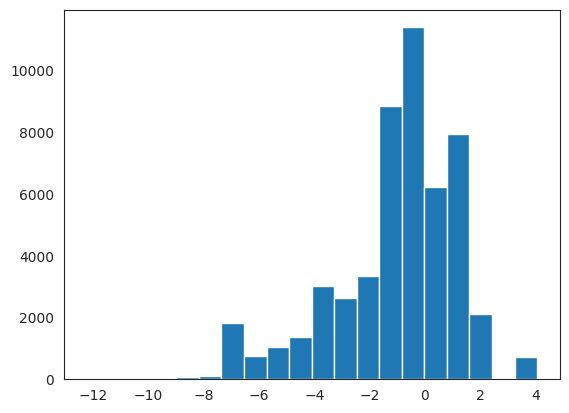

In [25]:
at = np.reshape(atari_200m_iter_scores_norm['Rainbow'], (-1))
at = np.reshape(atari_200m_iter_scores_norm['DQN (Nature)'], (-1))

plt.hist(np.log(at+0.001), bins = 20)